In [78]:
import pandas as pd
import numpy as np
from copy import deepcopy
from collections import defaultdict

import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
import seaborn as sns
import scienceplots
plt.style.use(['science', 'no-latex'])

import os
import sys
sys.path.append(os.path.abspath('.'))
from src.plots import set_size

labelmap = {
    "cnn": "1D-CNN + MLP",
    "mlp_onehot": "MLP (One-hot)",
    "xgb": "XGBoost (One-hot)",
    # "mean_transformer": "Transformer (Mean Pooling)",
}
SAMPLES_TO_SCORES = {
    0: 0.0,
    1: 0.003,
    5: 0.01,
    14: 0.03,
    50: 0.1,
    150: 0.3,
    500: 1.0,
    1500: 3.0
}
SCORES_TO_SAMPLES = {v: k for k, v in SAMPLES_TO_SCORES.items()}

LOGS_DIR = "logs_adversarial_poisoning_backdoor"
LIM = 100000
SUBDIRS_SAME_LIM = [os.path.join(LOGS_DIR, x) for x in os.listdir(LOGS_DIR) if str(LIM) in x]
SUBDIRS_SAME_LIM

PLOT_BACKDOOR_TOKENS = 32

Example score file:

```
{
    "tpr_backdoor": 0,
    "f1_backdoor": 0.9447024060785142,
    "acc_backdoor": 0.8952,
    "auc_backdoor": null,
    "misclassified_backdoor": 524,
    "misclassified_malicious_backdoor": 524,
    "misclassified_benign_backdoor": 0,
    "tpr_orig": 0,
    "f1_orig": 1.0,
    "acc_orig": 1.0,
    "auc_orig": null,
    "misclassified_orig": 0,
    "misclassified_malicious_orig": 0,
    "misclassified_benign_orig": 0,
    "tpr_orig_full": 1.0,
    "f1_orig_full": 0.999990000099999,
    "acc_orig_full": 0.99999,
    "auc_orig_full": 0.9999899999999999,
    "misclassified_orig_full": 1,
    "misclassified_malicious_orig_full": 0,
    "misclassified_benign_orig_full": 1
}
```

In [79]:
def read_scores_from_dir(directory, model_type):

    wordpuncts = [x for x in os.listdir(directory) if "wordpunct" in x]
    samples_to_ratio = {int(x.split("_")[7]): float(x.split("_")[-1].replace(".json", "")) for x in wordpuncts}
    ratio_to_samples = {v: k for k, v in samples_to_ratio.items()}

    score_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.startswith("poisoned_scores_")]
    scores_ddict = defaultdict(dict)
    for score_file in score_files:
        if model_type not in score_file:
            continue
        
        with open(score_file) as f:
            scores = json.load(f)
            # loop over values in scores and if nan then replace with 0
            for metric, value in scores.items():
                if value is None:
                    scores[metric] = 0
                elif np.isnan(value):
                    scores[metric] = 0

        poison_samples = int(score_file.split("poison_samples_")[1].split("_")[0].replace(".json", ""))

        # these both are properties of score file to be used within DataFrame
        poison_ratio = float(samples_to_ratio[poison_samples])
        backdoor_tokens = int(score_file.split("_")[-1].replace(".json",""))

        scores_ddict[poison_ratio][backdoor_tokens] = scores
    
    # sort by poison ratio
    scores_ddict = dict(sorted(scores_ddict.items(), key=lambda x: x[0]))
    # sort each dict by backdoor tokens
    for k, v in scores_ddict.items():
        scores_ddict[k] = dict(sorted(v.items(), key=lambda x: x[0]))
    
    return scores_ddict


def convert_ddict_to_dataframe(data):
    rows = []
    for epsilon, subdict in data.items():
        for num_layers, metrics in subdict.items():
            # Split keys further as backdoor, orig, and orig_full
            row = {'poison_ratio': epsilon, 'backdoor_tokens': num_layers}
            for key, value in metrics.items():
                row[key] = value
            rows.append(row)

    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(rows)
    return df


def add_base_rows(summary_df):
    summary_df = summary_df.copy()
    # Retrieve the base row for poison_ratio 0.000 and backdoor_tokens 0
    base_row = summary_df.xs((0.000, 0))
    
    # Get unique poison_ratios except 0.000
    poison_ratios = summary_df.index.get_level_values('poison_ratio').unique()
    poison_ratios = poison_ratios[poison_ratios != 0.000]

    # Iterate over each poison_ratio and insert the base_row with backdoor_tokens set to 0
    for ratio in poison_ratios:
        summary_df.loc[(ratio, 0), :] = base_row
    
    # If 'backdoor_tokens' index is not already sorted, we need to sort it to properly align the rows
    summary_df = summary_df.sort_index()

    # remove the base row for poison_ratio 0.000 and backdoor_tokens 0
    # summary_df = summary_df.drop((0.000, 0), axis=0)

    return summary_df


def expand_base_poison_ratio(summary_df):
    summary_df = summary_df.copy()
    # Retrieve the base row for poison_ratio 0.000
    base_rows = summary_df.xs(0.000, level='poison_ratio', drop_level=False)
    
    # Get all unique backdoor_tokens values across all poison_ratios
    all_backdoor_tokens = summary_df.index.get_level_values('backdoor_tokens').unique()
    
    # Filter out the backdoor_tokens that are already present for poison_ratio 0.000
    existing_tokens = base_rows.index.get_level_values('backdoor_tokens')
    new_tokens = all_backdoor_tokens.difference(existing_tokens)

    # Create new rows for each new token, copying the values from the base row
    for token in new_tokens:
        # Assuming the first row is the base row that should be replicated
        base_row = base_rows.iloc[0]
        new_index = (0.000, token)
        summary_df.loc[new_index, :] = base_row

    # Sort the index to ensure proper alignment
    summary_df = summary_df.sort_index()

    return summary_df


def mean_std_dfs(*dataframes):
    # Get a union of columns from all DataFrames
    all_columns = pd.Index([])
    for df in dataframes:
        all_columns = all_columns.union(df.columns, sort=False)

    # Reindex DataFrames to have the same columns with NaN for missing data
    reindexed_dfs = [df.reindex(columns=all_columns).sort_index(axis=1) for df in dataframes]

    # Combine reindexed DataFrames
    combined_df = pd.concat(reindexed_dfs, ignore_index=True)

    # Group by 'poison_ratio' and 'backdoor_tokens', ignoring NaN values in the aggregation
    grouped = combined_df.groupby(['poison_ratio', 'backdoor_tokens'], dropna=False)

    # Calculate mean and std while skipping NaN values
    mean_df = grouped.mean()
    std_df = grouped.std(ddof=0)  # Using sample standard deviation by default

    # Combine mean and std into a summary DataFrame
    summary_df = pd.concat([mean_df, std_df], axis=1, keys=['mean', 'std'])

    # Convert 'backdoor_tokens' index level to int
    summary_df.index = summary_df.index.set_levels(summary_df.index.levels[1].astype(int), level=1)

    # Add base rows for poison_ratio 0.000 and backdoor_tokens 0
    summary_df = add_base_rows(summary_df)

    # expand baseline tokens in base poison ratio
    summary_df = expand_base_poison_ratio(summary_df)

    return summary_df


def parse_scores(directories, model_type):
    dfs = []
    for folder in directories:
        dfs.append(convert_ddict_to_dataframe(read_scores_from_dir(folder, model_type)))

    df = mean_std_dfs(*dfs)
    return df


metrics = [
    "f1_backdoor",
    "acc_backdoor",
    "tpr_backdoor",
    "misclassified_malicious_backdoor", 
    "misclassified_benign_backdoor",
    "f1_orig",
    "acc_orig",
    "tpr_orig",
    "misclassified_malicious_orig",
    "misclassified_benign_orig",
    "f1_orig_full",
    "acc_orig_full",
    "tpr_orig_full",
    "misclassified_malicious_orig_full",
    "misclassified_benign_orig_full",
]


In [80]:
def plot_backdoor_results(df, model_name, metric: str, poison_ratio, backdoor_tokens, color, ax=None, linestyle="--", marker="o"):
    zero_substitute = 0.001 # for log scale when poison ratio is 0
    # metric_name = metric.replace("_backdoor", "").replace("_orig", "").replace("_orig_full", "")
    metric_name = metric.replace("_", " ").capitalize()
    metric_name = metric_name.replace("Acc", "Accuracy")
    metric_name = metric_name.replace("benign", "Benign")
    metric_name = metric_name.replace("malicious", "Malicious")
    metric_name = metric_name.replace("backdoor", "(Backdoored Test Set Subsample)")
    metric_name = metric_name.replace("orig full", "(Original Test Set)")
    metric_name = metric_name.replace("orig", "(Original Test Set Subsample)")

    # either poison ratio or backdoor tokens should be slice(None)
    assert (poison_ratio == slice(None)) != (backdoor_tokens == slice(None))

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=set_size())

    scores_mean = deepcopy(df.loc[(poison_ratio, backdoor_tokens), ("mean", metric)])
    scores_std = deepcopy(df.loc[(poison_ratio, backdoor_tokens), ("std", metric)])

    if backdoor_tokens == slice(None):
        x = scores_mean.index.levels[1]
        xlabel = "Backdoor Tokens"
        xscale = "linear"
        metric_name = f"Poison Ratio: {poison_ratio}% ({SCORES_TO_SAMPLES[poison_ratio]} Samples) of Train Set\n" + metric_name
    if poison_ratio == slice(None):
        x = scores_mean.index.levels[0]
        xlabel = "Poison Ratio"
        xscale = "log"
        metric_name = f"Backdoor Tokens: {backdoor_tokens}\n" + metric_name
        x = [zero_substitute if i == 0 else i for i in x]

    # # mean as scatter plot with larger size, and std as errbars
    ax.scatter(x, scores_mean, marker=marker, label=model_name, color=color, s=100)
    ax.errorbar(x, scores_mean, yerr=scores_std, ls="none", capsize=3, color=color, label=model_name, linewidth=2)
    ax.plot(x, scores_mean, ls=linestyle, color=color, label=model_name, linewidth=2)

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_title(metric_name, fontsize=14)
    ax.set_xscale(xscale)

    if poison_ratio == slice(None):
        vals = ax.get_xticks()
        vals = np.append(vals, zero_substitute)
        ax.xaxis.set_major_locator(mticker.FixedLocator(vals))
        xl = []
        for x in vals:
            if x == zero_substitute:
                xl.append("0%")
            elif x == 0.001:
                xl.append("{:.3%}".format(x/100))
            else:
                xl.append("{:.2%}".format(x/100))
        ax.set_xticklabels(xl, fontsize=14)
    else:
        ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    return ax


def joint_metric_plot(metric, poison_ratio, backdoor_tokens):
    # create colors the size of the number of patterns
    colors = sns.color_palette("tab10", len(labelmap))

    legend_handles = []
    fig, ax = plt.subplots(1, 1, figsize=set_size())
    for i, model_type in enumerate(labelmap.keys()):
        df = parse_scores(SUBDIRS_SAME_LIM, model_type)
        plot_backdoor_results(df, "", metric, poison_ratio, backdoor_tokens, color=colors[i], ax=ax)
        legend_handles.append(Line2D([0], [0], linestyle="--", color=colors[i], lw=2, label=labelmap[model_type]))

    _ = ax.legend(handles=legend_handles, fontsize=14)
    return ax


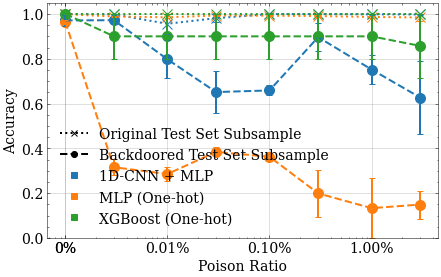

In [81]:
legend_handles = []
fig, ax = plt.subplots(1, 1, figsize=set_size())
colors = ["tab:blue", "tab:orange", "tab:green"]
linestyles = [":", "--", "-."]
markers = ["x", "o"]
legend_names = {
    "acc_orig": "Original Test Set Subsample",
    "acc_backdoor": "Backdoored Test Set Subsample",
}
for j, metric in enumerate(legend_names.keys()):
    legend_handles.append(Line2D([0], [0], linestyle=linestyles[j], color="black", lw=2, marker=markers[j], label=legend_names[metric]))
    for i, model_type in enumerate(labelmap.keys()):
        df = parse_scores(SUBDIRS_SAME_LIM, model_type)
        plot_backdoor_results(df, "", metric, slice(None), PLOT_BACKDOOR_TOKENS, color=colors[i], ax=ax, linestyle=linestyles[j], marker=markers[j])
        if j == 1:
            legend_handles.append(Line2D([0], [0], linestyle="none", marker='s', color=colors[i], lw=2, label=labelmap[model_type]))
ax.set_ylim(0.0, 1.05)
ax.set_title("")#f"Accuracy with Backdoor Tokens: 8", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
# grid with transparent lines
ax.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
_ = ax.legend(handles=legend_handles, fontsize=14, loc="lower left")

# save as pdf in /img
plt.savefig("img/backdoor_results.pdf", bbox_inches='tight')

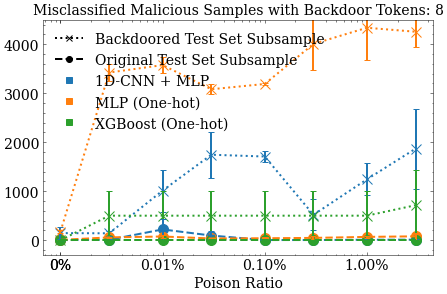

In [82]:
legend_handles = []
fig, ax = plt.subplots(1, 1, figsize=set_size())
colors = ["tab:blue", "tab:orange", "tab:green"]
linestyles = [":", "--"]
markers = ["x", "o"]
legend_names = {
    "misclassified_malicious_backdoor": "Backdoored Test Set Subsample",
    "misclassified_malicious_orig": "Original Test Set Subsample",
}
for j, metric in enumerate(legend_names.keys()):
    legend_handles.append(Line2D([0], [0], linestyle=linestyles[j], color="black", lw=2, marker=markers[j], label=legend_names[metric]))
    for i, model_type in enumerate(labelmap.keys()):
        df = parse_scores(SUBDIRS_SAME_LIM, model_type)
        plot_backdoor_results(df, "", metric, slice(None), PLOT_BACKDOOR_TOKENS, color=colors[i], ax=ax, linestyle=linestyles[j], marker=markers[j])
        if j == 1:
            legend_handles.append(Line2D([0], [0], linestyle="none", marker='s', color=colors[i], lw=2, label=labelmap[model_type]))
ax.set_ylim(-300, 4500)
ax.set_title(f"Misclassified Malicious Samples with Backdoor Tokens: 8", fontsize=14)
_ = ax.legend(handles=legend_handles, fontsize=14, loc='upper left')

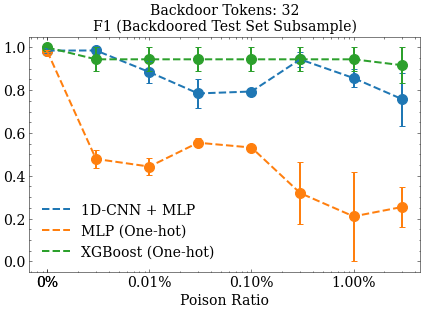

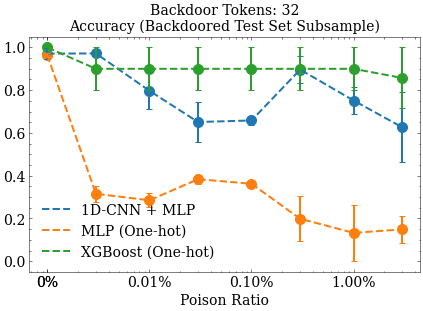

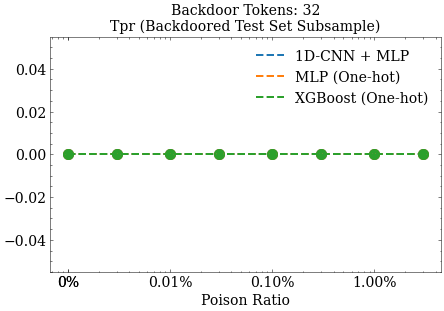

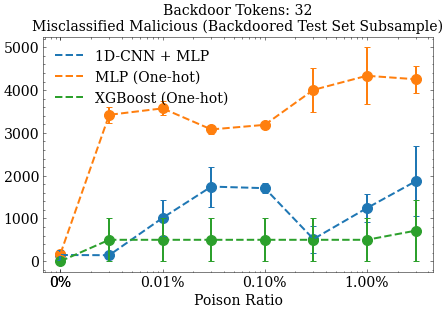

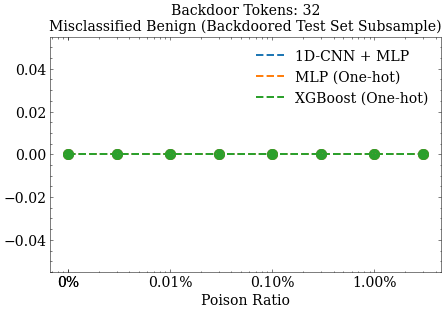

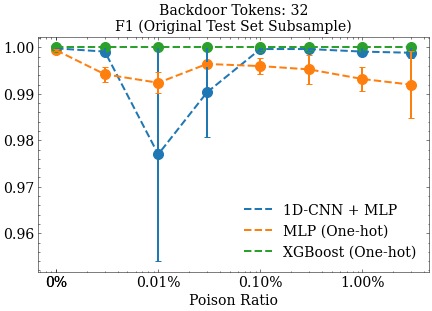

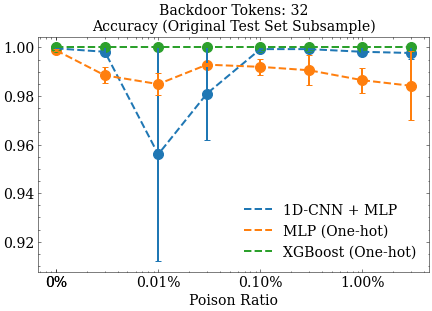

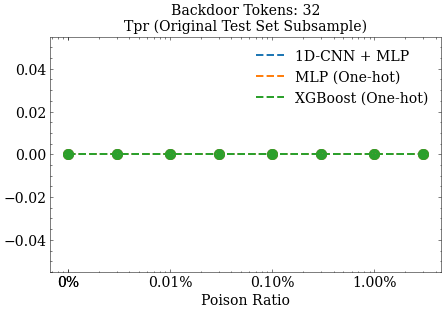

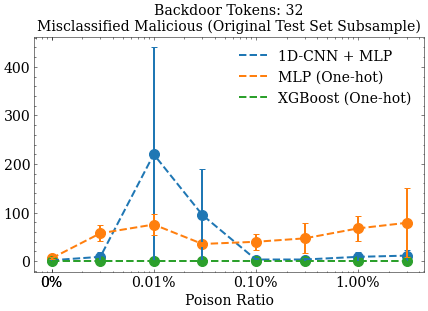

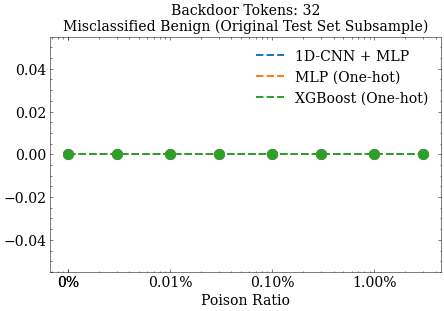

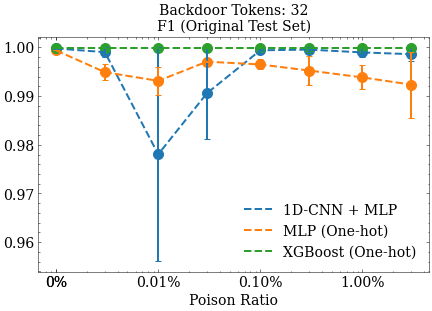

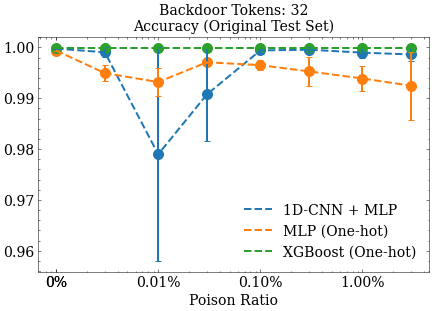

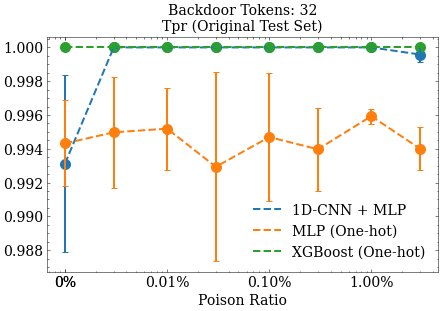

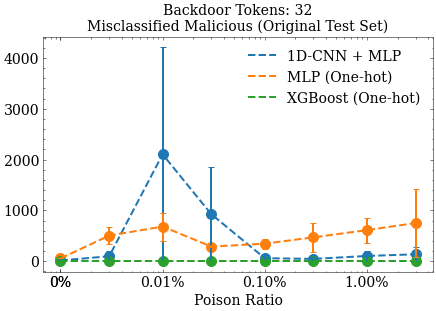

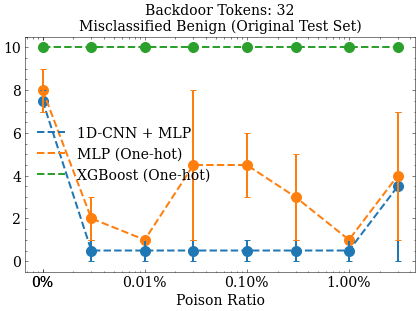

In [83]:
for metric in metrics:
    df = joint_metric_plot(metric, slice(None), PLOT_BACKDOOR_TOKENS)

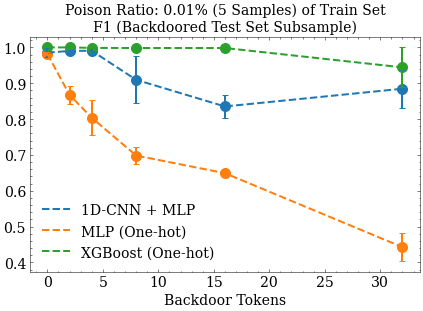

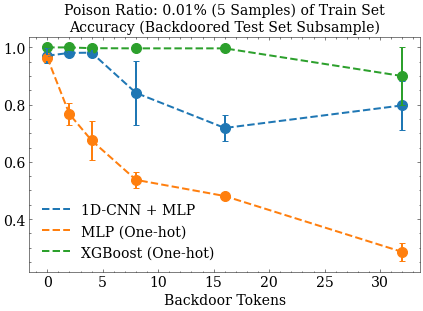

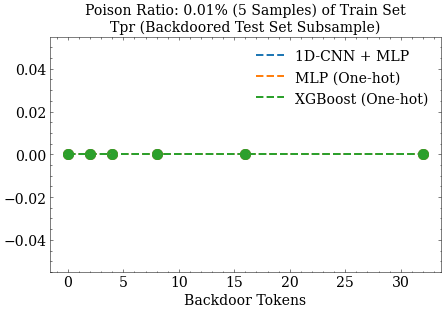

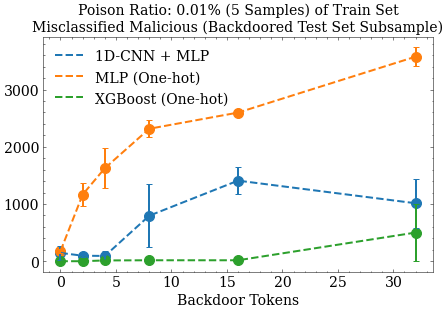

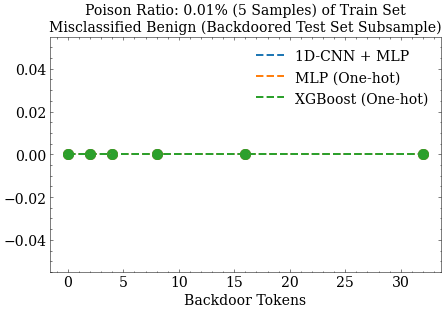

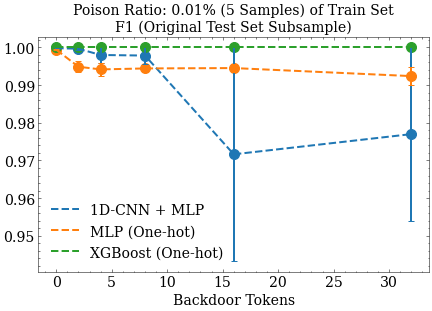

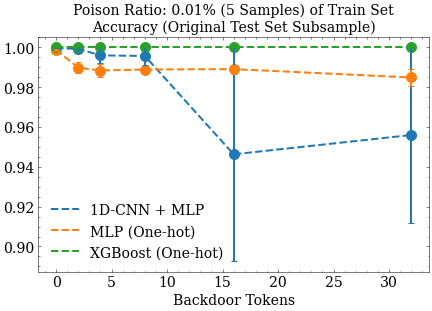

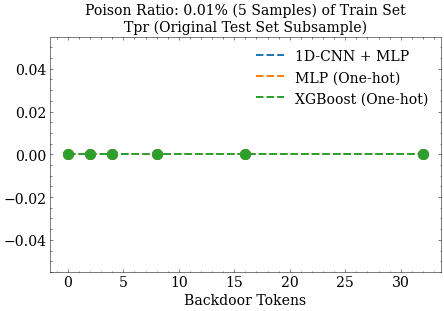

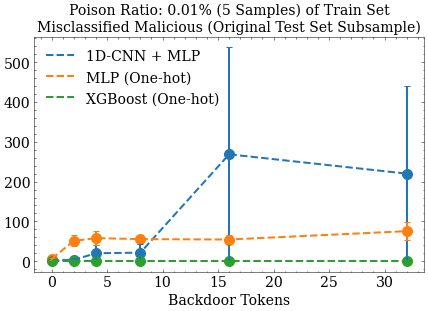

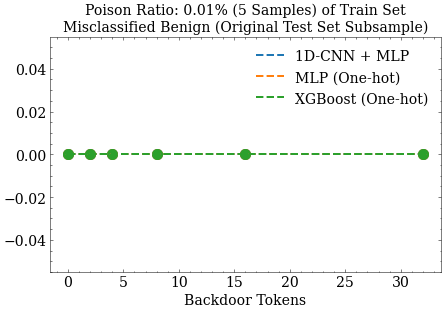

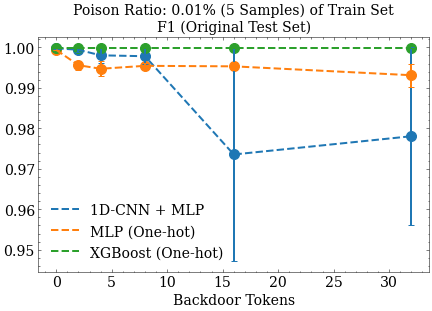

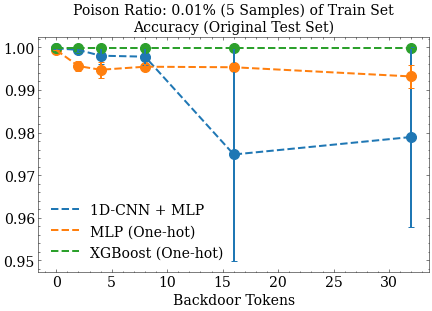

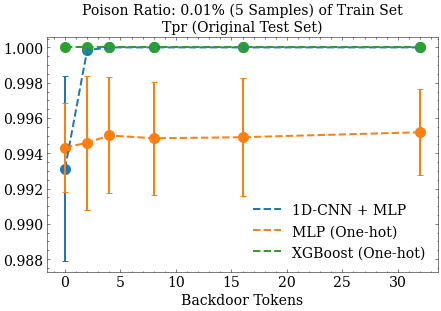

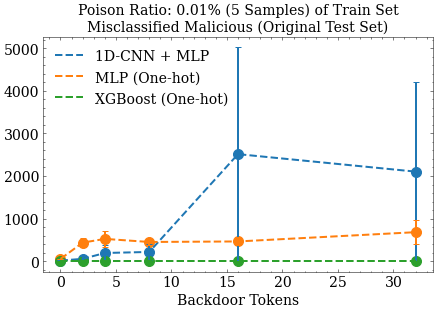

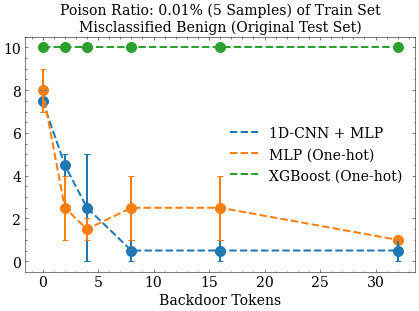

In [84]:
for metric in metrics:
    joint_metric_plot(metric, SAMPLES_TO_SCORES[5], slice(None))

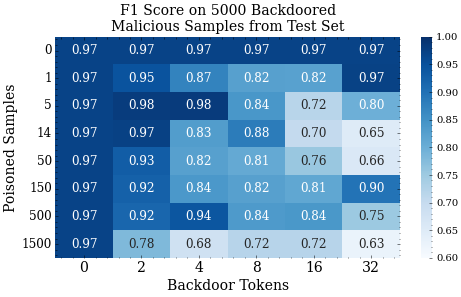

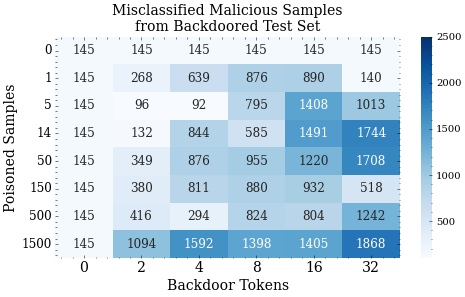

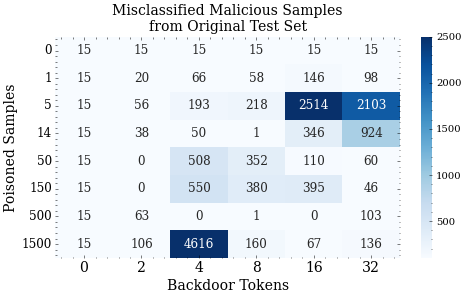

In [85]:
cnn_df = parse_scores(SUBDIRS_SAME_LIM, "cnn")

heatmap_df = cnn_df.loc[:, ("mean", "acc_backdoor")]
heatmap_df = heatmap_df.unstack()

# change heatmap_df index of poison ratio to samples
heatmap_df.index = heatmap_df.index.map(lambda x: SCORES_TO_SAMPLES[x])

fig, ax = plt.subplots(1, 1, figsize=set_size())
# plot heatmap with nice color gradient
# put cbar label horizontally to the right with specific width and height
cbar_kws = {}#'label': 'Misclacified Malicious', 'shrink': 0.8}#, 'orientation': 'horizontal'}
sns.heatmap(heatmap_df, cmap="Blues", ax=ax, annot=True, fmt=".2f", cbar=True, cbar_kws=cbar_kws, vmin=0.6, vmax=1, annot_kws={"fontsize": 12})
ax.set_xlabel("Backdoor Tokens", fontsize=14)
ax.set_ylabel("Poisoned Samples", fontsize=14)
ax.set_title("F1 Score on 5000 Backdoored\nMalicious Samples from Test Set", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=12, rotation=0)
plt.tight_layout()

# ========================================

heatmap_df = cnn_df.loc[:, ("mean", "misclassified_malicious_backdoor")]
heatmap_df = heatmap_df.unstack()
# change heatmap_df index of poison ratio to samples
heatmap_df.index = heatmap_df.index.map(lambda x: SCORES_TO_SAMPLES[x])

fig, ax = plt.subplots(1, 1, figsize=set_size())
# plot heatmap with nice color gradient
# cbar kws -- cbar title fontsize 14 and put on top
cbar_kws = {}#'label': 'Misclacified Malicious', 'orientation': 'horizontal', 'pad': 0.2, 'aspect': 50, 'shrink': 0.8}
sns.heatmap(heatmap_df, cmap="Blues", ax=ax, annot=True, fmt=".0f", cbar=True, cbar_kws=cbar_kws, vmin=100, vmax=2500, annot_kws={"fontsize": 12})
ax.set_xlabel("Backdoor Tokens", fontsize=14)
ax.set_ylabel("Poisoned Samples", fontsize=14)
ax.set_title("Misclassified Malicious Samples\nfrom Backdoored Test Set", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=12, rotation=0)
plt.tight_layout()

# ========================================

heatmap_df = cnn_df.loc[:, ("mean", "misclassified_malicious_orig_full")]
heatmap_df = heatmap_df.unstack()
# change heatmap_df index of poison ratio to samples
heatmap_df.index = heatmap_df.index.map(lambda x: SCORES_TO_SAMPLES[x])

fig, ax = plt.subplots(1, 1, figsize=set_size())
# plot heatmap with nice color gradient
# cbar kws -- cbar title fontsize 14 and put on top
cbar_kws = {}#'label': 'Misclacified Malicious', 'orientation': 'horizontal', 'pad': 0.2, 'aspect': 50, 'shrink': 0.8}
sns.heatmap(heatmap_df, cmap="Blues", ax=ax, annot=True, fmt=".0f", cbar=True, cbar_kws=cbar_kws, vmin=100, vmax=2500, annot_kws={"fontsize": 12})
ax.set_xlabel("Backdoor Tokens", fontsize=14)
ax.set_ylabel("Poisoned Samples", fontsize=14)
ax.set_title("Misclassified Malicious Samples\nfrom Original Test Set", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=12, rotation=0)
plt.tight_layout()

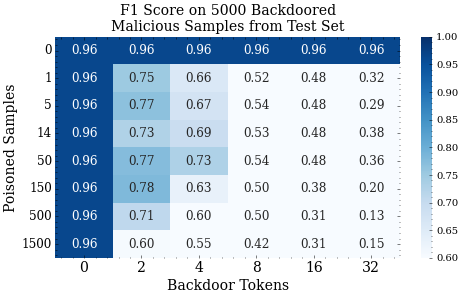

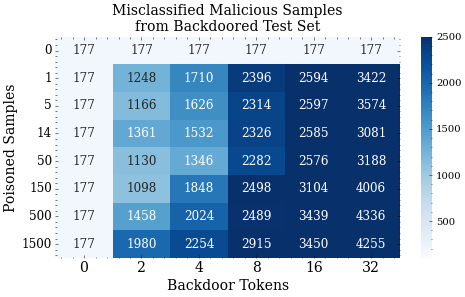

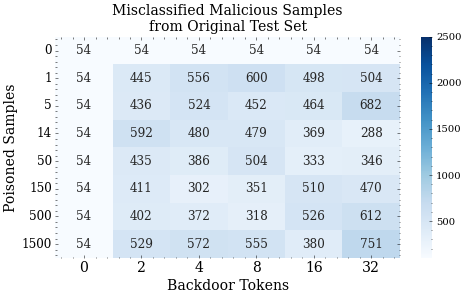

In [86]:
cnn_df = parse_scores(SUBDIRS_SAME_LIM, "mlp_onehot")

heatmap_df = cnn_df.loc[:, ("mean", "acc_backdoor")]
heatmap_df = heatmap_df.unstack()

# change heatmap_df index of poison ratio to samples
heatmap_df.index = heatmap_df.index.map(lambda x: SCORES_TO_SAMPLES[x])

fig, ax = plt.subplots(1, 1, figsize=set_size())
# plot heatmap with nice color gradient
# put cbar label horizontally to the right with specific width and height
cbar_kws = {}#'label': 'Misclacified Malicious', 'shrink': 0.8}#, 'orientation': 'horizontal'}
sns.heatmap(heatmap_df, cmap="Blues", ax=ax, annot=True, fmt=".2f", cbar=True, cbar_kws=cbar_kws, vmin=0.6, vmax=1, annot_kws={"fontsize": 12})
ax.set_xlabel("Backdoor Tokens", fontsize=14)
ax.set_ylabel("Poisoned Samples", fontsize=14)
ax.set_title("F1 Score on 5000 Backdoored\nMalicious Samples from Test Set", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=12, rotation=0)
plt.tight_layout()

# ========================================

heatmap_df = cnn_df.loc[:, ("mean", "misclassified_malicious_backdoor")]
heatmap_df = heatmap_df.unstack()
# change heatmap_df index of poison ratio to samples
heatmap_df.index = heatmap_df.index.map(lambda x: SCORES_TO_SAMPLES[x])

fig, ax = plt.subplots(1, 1, figsize=set_size())
# plot heatmap with nice color gradient
# cbar kws -- cbar title fontsize 14 and put on top
cbar_kws = {}#'label': 'Misclacified Malicious', 'orientation': 'horizontal', 'pad': 0.2, 'aspect': 50, 'shrink': 0.8}
sns.heatmap(heatmap_df, cmap="Blues", ax=ax, annot=True, fmt=".0f", cbar=True, cbar_kws=cbar_kws, vmin=100, vmax=2500, annot_kws={"fontsize": 12})
ax.set_xlabel("Backdoor Tokens", fontsize=14)
ax.set_ylabel("Poisoned Samples", fontsize=14)
ax.set_title("Misclassified Malicious Samples\nfrom Backdoored Test Set", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=12, rotation=0)
plt.tight_layout()

# ========================================

heatmap_df = cnn_df.loc[:, ("mean", "misclassified_malicious_orig_full")]
heatmap_df = heatmap_df.unstack()
# change heatmap_df index of poison ratio to samples
heatmap_df.index = heatmap_df.index.map(lambda x: SCORES_TO_SAMPLES[x])

fig, ax = plt.subplots(1, 1, figsize=set_size())
# plot heatmap with nice color gradient
# cbar kws -- cbar title fontsize 14 and put on top
cbar_kws = {}#'label': 'Misclacified Malicious', 'orientation': 'horizontal', 'pad': 0.2, 'aspect': 50, 'shrink': 0.8}
sns.heatmap(heatmap_df, cmap="Blues", ax=ax, annot=True, fmt=".0f", cbar=True, cbar_kws=cbar_kws, vmin=100, vmax=2500, annot_kws={"fontsize": 12})
ax.set_xlabel("Backdoor Tokens", fontsize=14)
ax.set_ylabel("Poisoned Samples", fontsize=14)
ax.set_title("Misclassified Malicious Samples\nfrom Original Test Set", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=12, rotation=0)
plt.tight_layout()

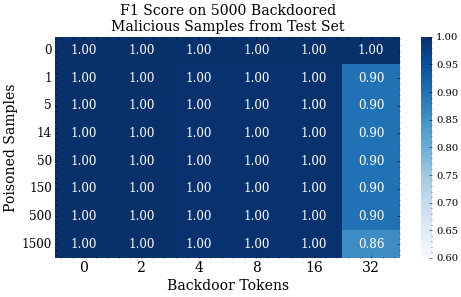

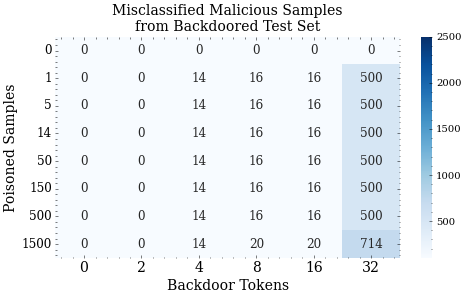

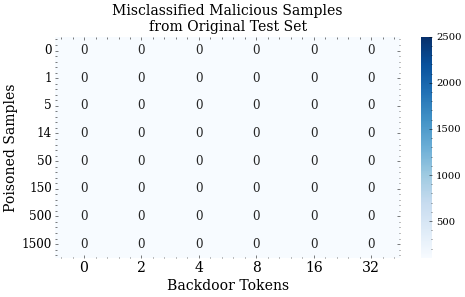

In [87]:
cnn_df = parse_scores(SUBDIRS_SAME_LIM, "xgb_onehot")

heatmap_df = cnn_df.loc[:, ("mean", "acc_backdoor")]
heatmap_df = heatmap_df.unstack()

# change heatmap_df index of poison ratio to samples
heatmap_df.index = heatmap_df.index.map(lambda x: SCORES_TO_SAMPLES[x])

fig, ax = plt.subplots(1, 1, figsize=set_size())
# plot heatmap with nice color gradient
# put cbar label horizontally to the right with specific width and height
cbar_kws = {}#'label': 'Misclacified Malicious', 'shrink': 0.8}#, 'orientation': 'horizontal'}
sns.heatmap(heatmap_df, cmap="Blues", ax=ax, annot=True, fmt=".2f", cbar=True, cbar_kws=cbar_kws, vmin=0.6, vmax=1, annot_kws={"fontsize": 12})
ax.set_xlabel("Backdoor Tokens", fontsize=14)
ax.set_ylabel("Poisoned Samples", fontsize=14)
ax.set_title("F1 Score on 5000 Backdoored\nMalicious Samples from Test Set", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=12, rotation=0)
plt.tight_layout()

# ========================================

heatmap_df = cnn_df.loc[:, ("mean", "misclassified_malicious_backdoor")]
heatmap_df = heatmap_df.unstack()
# change heatmap_df index of poison ratio to samples
heatmap_df.index = heatmap_df.index.map(lambda x: SCORES_TO_SAMPLES[x])

fig, ax = plt.subplots(1, 1, figsize=set_size())
# plot heatmap with nice color gradient
# cbar kws -- cbar title fontsize 14 and put on top
cbar_kws = {}#'label': 'Misclacified Malicious', 'orientation': 'horizontal', 'pad': 0.2, 'aspect': 50, 'shrink': 0.8}
sns.heatmap(heatmap_df, cmap="Blues", ax=ax, annot=True, fmt=".0f", cbar=True, cbar_kws=cbar_kws, vmin=100, vmax=2500, annot_kws={"fontsize": 12})
ax.set_xlabel("Backdoor Tokens", fontsize=14)
ax.set_ylabel("Poisoned Samples", fontsize=14)
ax.set_title("Misclassified Malicious Samples\nfrom Backdoored Test Set", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=12, rotation=0)
plt.tight_layout()

# ========================================

heatmap_df = cnn_df.loc[:, ("mean", "misclassified_malicious_orig_full")]
heatmap_df = heatmap_df.unstack()
# change heatmap_df index of poison ratio to samples
heatmap_df.index = heatmap_df.index.map(lambda x: SCORES_TO_SAMPLES[x])

fig, ax = plt.subplots(1, 1, figsize=set_size())
# plot heatmap with nice color gradient
# cbar kws -- cbar title fontsize 14 and put on top
cbar_kws = {}#'label': 'Misclacified Malicious', 'orientation': 'horizontal', 'pad': 0.2, 'aspect': 50, 'shrink': 0.8}
sns.heatmap(heatmap_df, cmap="Blues", ax=ax, annot=True, fmt=".0f", cbar=True, cbar_kws=cbar_kws, vmin=100, vmax=2500, annot_kws={"fontsize": 12})
ax.set_xlabel("Backdoor Tokens", fontsize=14)
ax.set_ylabel("Poisoned Samples", fontsize=14)
ax.set_title("Misclassified Malicious Samples\nfrom Original Test Set", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=12, rotation=0)
plt.tight_layout()